## Regression with Logic Tensor Networks

This is a basic example in which we use LTN for training a regression estimator. The essence of regression is to approximate a function $f(x)=y$. We are given examples of this function $x_i,y_i$ with $f(x_i)=y_i$. From the examples, we need to estimate a function $f^*$ that approximates $f$. In LTN we can directly model this by defining $f^*$ as a learnable/trainable function with some parameters that are constrained through data. Additionally we need a notion of $=$. Here we use a Euclidian distance/similarity to get a smooth $=$ function. We define the following language and theory
* a set of points $x_i$ and $y_i$
* a definition of equality, modeled as a smooth similarity function $\mathrm{eq}(x,y)=\exp\big(-\sqrt{\sum_j (x_j-y_j)^2}\big)$,
* a learnable function $f^*$ for which the following constraints hold $\mathrm{eq}(f^*(x_i),y_i)$. The function $f^*$  approximates $f(x_i)=y_i$
* here, $f^*$ is modeled using a linear function with $f^*(x)=Wx+b$


In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import logictensornetworks_wrapper as ltnw
import logictensornetworks_library as ltnl

start=-1
end=1
training_size=10
testing_size=10
learning_rate = 0.01
slope=1.
var=0.1
epochs=1000


Define the regressor $f^*$.

In [2]:
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")
f=ltnw.function("f",1,1,fun_definition=lambda x: tf.add(tf.multiply(x, W), b));

We define the theory using a number of constants -- the training points (Notice there are other ways of achieving this using variables)

We define an $\mathrm{eq}$ function that defines equality $\mathrm{eq}(x,y)=\exp\big(-\sqrt{\sum_{i=j}^m(x_j-y_j)^2}\big)$ with $m$ being the dimensionality of the domain (here $2$). This function is equal to $1.$ iff $x,y$ are equal and approaches zero the further $x,y$ are in terms of Euclidian distance

In [3]:
ltnw.predicate("eq",2,lambda x,y: tf.exp(-tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x,y)),1,keepdims=True))));

Now let's define the data and theory. First, we generate training points $x_i,y_i$.

In [4]:
train_X = np.random.uniform(start,end,(training_size)).astype("float32")
train_Y = slope*train_X + np.random.normal(scale=var,size=len(train_X))
[ltnw.constant("x_%s" % i,[x]) for i,x in enumerate(train_X)]
[ltnw.constant("y_%s" % i,[y]) for i,y in enumerate(train_Y)]
print("constants defined: %s" % ",".join(sorted(ltnw.CONSTANTS.keys())))

constants defined: x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9


Next we can define the theory.

In [5]:
for f in ["eq(f(x_%s),y_%s)" % (i,i) for i in range(len(train_X))]:
    ltnw.axiom(f)
print("\n".join(sorted(ltnw.AXIOMS.keys())))

eq(f(x_0),y_0)
eq(f(x_1),y_1)
eq(f(x_2),y_2)
eq(f(x_3),y_3)
eq(f(x_4),y_4)
eq(f(x_5),y_5)
eq(f(x_6),y_6)
eq(f(x_7),y_7)
eq(f(x_8),y_8)
eq(f(x_9),y_9)


Initialize the knowledgebase and optimize

In [6]:
ltnw.initialize_knowledgebase(optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate))
ltnw.train(max_epochs=epochs)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.52985793
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.52985793
INFO:logictensornetworks_wrapper:TRAINING 100 sat level -----> 0.6724996
INFO:logictensornetworks_wrapper:TRAINING 200 sat level -----> 0.72394794
INFO:logictensornetworks_wrapper:TRAINING 300 sat level -----> 0.77136195
INFO:logictensornetworks_wrapper:TRAINING 400 sat level -----> 0.83094007
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> 0.87737787
INFO:logictensornetworks_wrapper:TRAINING 600 sat level -----> 0.931105
INFO:logictensornetworks_wrapper:TRAINING 700 sat level -----> 0.93681157
INFO:logictensornetworks_wrapper:TRAINING 800 sat level -----> 0.9368715
INFO:logictensornetworks_wrapper

0.93709934

Given that the model is trained we can now check any points in the domain and their mapping in $f$. Here we check the value of $f(2.0)$

In [7]:
ltnw.constant("t",[2.])
ltnw.ask("f(t)")

array([1.9487728], dtype=float32)

Visualize results training data

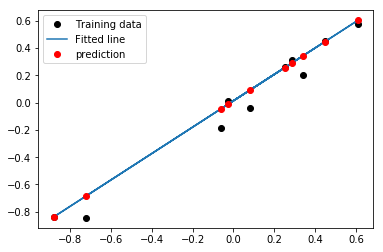

In [8]:
# visualize results on training data
ltnw.variable("?x",1)
prediction=ltnw.ask("f(?x)",feed_dict={"?x" : train_X.reshape(len(train_X),1)})
plt.figure()
plt.plot(train_X, train_Y, 'bo', label='Training data',color="black")
plt.plot(train_X, ltnw.SESSION.run(W) * train_X + ltnw.SESSION.run(b), label='Fitted line')
plt.plot(train_X, prediction, 'bo', label='prediction',color="red")
plt.legend()


Generate test data and visualize results

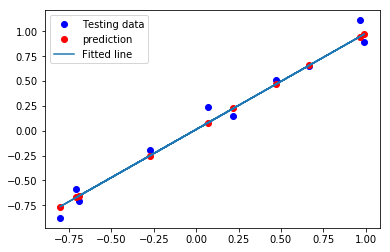

In [9]:
test_X = np.random.uniform(start,end,(testing_size)).astype("float32")
prediction=ltnw.ask("f(?x)",feed_dict={"?x" : test_X.reshape(len(test_X),1)})
test_Y = slope*test_X + np.random.normal(scale=var,size=len(test_X))
plt.figure()
plt.plot(test_X, test_Y, 'bo', label='Testing data')
plt.plot(test_X, prediction, 'bo', label='prediction',color="red")
plt.plot(test_X, ltnw.SESSION.run(W) * test_X + ltnw.SESSION.run(b), label='Fitted line')
plt.legend()
plt.show()